In [1]:
# --- Preprocessing ---
import pandas as pd
from sklearn.utils import resample
import numpy as np
from afinn import Afinn
import pickle

# --- Processing ---
import re
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import string
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import collections

# --- Postprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

class Verarbeitung():
    
    def __init__(self,data_here):
        """
            The data is given as a pandas file.
        """
        self.data_here = data_here
        self.my_info_dict = {}
        
        """
            Depending which dataset is used, this
            will load the bert-encoded dataset in 
            order to use it in the bert model. 
        """
        # 
        #with open('bert_emb2_0traintweets.pk', mode='rb') as f:
        with open('Datasets/bert_emb_0train_tweets.pk', mode='rb') as f:
            self.bert_here = pickle.load(f)

    def auskunft(self):
        """
            --------------
            --- STATUS ---
            --------------
            This function prints relevant information
            related to the data frame which is being
            updated after each preprocessing step. It
            has a dictionary to where the information 
            is added. 
        """
        self.data_length = len(self.data_here)
        self.my_info_dict['Dataset_Length'] = self.data_length
        self.data_column_names = [name for name in (self.data_here).columns]
        self.my_info_dict['Columns'] = self.data_column_names
        return self.my_info_dict
    
    def labels_to_numbers(self,text_field):
        """
            ---------------------
            --- PREPROCESSING ---
            ---------------------

        """
        if text_field in ['sentiment','label','airline_sentiment']:
            label_encoder = LabelEncoder()
            (self.data_here)['target'] = label_encoder.fit_transform((self.data_here)[text_field])
            self.classes = [k for k in label_encoder.classes_]
            self.my_info_dict['Classes'] = self.classes
            self.my_info_dict['Number_of_Classes'] = len(self.classes)
            self.transformed_classes = label_encoder.fit_transform(self.classes)
            self.my_info_dict['Transformed_Classes'] = list(self.transformed_classes)
            #self.classes_and_transformed_classes = dict(zip(self.classes,self.transformed_classes))
        
    def clean_the_tweets(self,text_field):
        """
            ----------------------
            ---- PREPROCESSING ---
            ----------------------
            It cleans the tweets, removing mentions, 
            url's, leaving only characters, deleting
            extra spaces, making every character 
            lower case and adds a column with the 
            name clean_tweet.
        """
        if text_field in ['text','tweet','sentiment','content']:
            (self.data_here)[text_field] = (self.data_here[text_field]).str.lower()
            mystring = r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
            self.data_here['clean_tweet'] = (self.data_here)[text_field].apply(lambda element: re.sub(mystring,"",element))
            self.data_column_names = [name for name in (self.data_here).columns]
            
    def tokens_and_more(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
            It creates tokens, then chooses the frquency of 
            the top fifty of them and displays them in a graph. 
        """
        if text_field in ['sentiment','label','airline_sentiment']:
            cvec = CountVectorizer()
            cvec.fit(self.data_here['clean_tweet'])
            doc_matrices = [cvec.transform(self.data_here[self.data_here[text_field] == k].clean_tweet) for k in self.my_info_dict['Classes']]
            doc_matrices_sums = [np.sum(my_sum,axis=0) for my_sum in doc_matrices]
            all_squeezed = [np.squeeze(np.asarray(k)) for k in doc_matrices_sums]
            term_freq_df = pd.DataFrame(all_squeezed,columns=cvec.get_feature_names()).transpose()
            term_freq_df.columns = self.my_info_dict['Classes']
            term_freq_df['total'] = sum([term_freq_df[k] for k in self.my_info_dict['Classes']])#term_freq_df['positive'] + term_freq_df['neutral'] + term_freq_df['negative']
            term_freq_df.sort_values(by='total', ascending=False)
            print(term_freq_df.sort_values(by='total', ascending=False).head())
            y_neg = np.arange(50)
            for kindex, class_is_here in enumerate(self.my_info_dict['Classes']):
                fig, ax = plt.subplots(figsize=(13,7))
                ax.set_axis_off()
                ax = fig.add_subplot(1,1,1)
                ax.bar(y_neg, term_freq_df.sort_values(by=class_is_here,ascending=False)[class_is_here][:50], align='center',alpha=0.5)
                ax.set_xticks(y_neg)
                ax.set_xticklabels(term_freq_df.sort_values(by=class_is_here,ascending=False)[class_is_here][:50].index,rotation='vertical')
                ax.set_ylabel('Frequency')
                ax.set_xlabel('Top 50 %s tokens'%(self.my_info_dict['Classes'][kindex]))
                ax.set_title('Top 50 tokens in %s tweets'%(self.my_info_dict['Classes'][kindex]))
            plt.show()

    def normalizer(self,text_field):
        """
            ---------------------
            --- PREPROCESSING ---
            ---------------------
            This function removes the stopwords
            and adds the tokens per tweet in a 
            new column. This is part of the 
            preprocessing because this column
            plays an important role as the
            input in the models. 
        """
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        
        def tokenize(s): 
            return re_tok.sub(r' \1 ', s).split()
        
        self.data_here['tokenized'] = self.data_here[text_field].apply(lambda row: tokenize(row))
        stop = set(stopwords.words('english'))
        stop.update(['amp', 'rt', 'cc'])
        stop = stop - set(['no', 'not'])
        
        def remove_stopwords(row):
            return [t for t in row if t not in stop]
        
        self.data_here['tokenized'] = self.data_here['tokenized'].apply(lambda row: remove_stopwords(row))
        
        def update_vocab_counter(row):
            for word in row:
                vocab_counter[word] += 1
                
        vocab_counter = collections.Counter()
        self.data_here['tokenized'].apply(update_vocab_counter)
        vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)
        
        self.my_info_dict['Vocabulary'] = len(vocab)
        max_words = 5000
        self.my_info_dict['Vocabulary_Size_to_Use'] = max_words
        w2id = {w:i+1 for i, w in enumerate(vocab[:max_words-1])}
        w2id['unk'] = 0
        
        self.my_info_dict['Embedding_Dimension_to_Use'] = 50
        
        def transform_to_ids(row):
            return [w2id[w] if w in w2id else w2id['unk'] for w in row]
        
        self.data_here['tokenized_int'] = self.data_here['tokenized'].apply(lambda x: transform_to_ids(x))
        lens = self.data_here['tokenized_int'].apply(lambda x: len(x))
        maxlen = int(np.floor(max(lens)))
        self.my_info_dict['Words_Per_Document'] = maxlen
        
    def prozent_wrt(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
            This function computes the number of sentiments
            in the target column and returns a plot.
        """
        if text_field in ['sentiment','label','airline_sentiment']:
            percentage = (self.data_here).groupby([text_field]).count()
            percentage['clean_tweet'].plot(kind='bar', 
                                           figsize=(8, 6), 
                                           legend=False, 
                                           title='Number of tweets by class')
            plt.show()
       
    def afinn_stuff(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
        """
        af = Afinn()

        # compute sentiment scores (polarity) and labels
        sentiment_scores = [af.score(article) for article in self.data_here['clean_tweet']]
        sentiment_category = ['positive' if score > 0 
                                  else 'negative' if score < 0 
                                      else 'neutral' 
                                          for score in sentiment_scores]

        # sentiment statistics per news category
        if text_field in ['sentiment','label','airline_sentiment']:
            df = pd.DataFrame([list(self.data_here[text_field]), sentiment_scores, sentiment_category]).T
            df.columns = ['sentiment', 'sentiment_score', 'sentiment_category']
            df['sentiment_score'] = df.sentiment_score.astype('float')
            df.groupby(by=['sentiment']).describe()

            f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
            sp = sns.stripplot(x='sentiment', y="sentiment_score",hue='sentiment', data=df, ax=ax1)
            bp = sns.boxplot(x='sentiment', y="sentiment_score", hue='sentiment', data=df, palette="Set2", ax=ax2)
            t = f.suptitle('Visualizing Sentiment', fontsize=14)
            plt.show()
          
    def patterns_of(self,sentiment_field,sentiment):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
        """
        def ngrams(input_list):
            #onegrams = input_list
            bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
            trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
            return bigrams+trigrams
        self.data_here['grams'] = self.data_here['tokenized'].apply(ngrams)

        def count_words(input):
            cnt = collections.Counter()
            for row in input:
                for word in row:
                    cnt[word] += 1
            return cnt
        
        self.data_here[(self.data_here[sentiment_field] == sentiment)][['grams']].apply(count_words)['grams'].most_common(20)
        return self.data_here[(self.data_here[sentiment_field] == sentiment)][['grams']].apply(count_words)['grams'].most_common(20)
    
    def first_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
            The first model resembles a linear model,
            where just a softmax function is used at 
            the end of the process once we have set
            the variables for the embedding. 
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.data_here['tokenized_int'].values, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        x_train = pad_sequences(X_train, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        x_test = pad_sequences(X_test, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def baseline_model():
            model = Sequential([Embedding(input_dim=self.my_info_dict['Vocabulary_Size_to_Use'], 
                                          output_dim=self.my_info_dict['Embedding_Dimension_to_Use'], 
                                          input_length=self.my_info_dict['Words_Per_Document']),
                                Flatten(),
                                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax')])
            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
            return model
        
        estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, x_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/linear_0.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = baseline_model()
        model.fit(x_train, dummy_y, validation_data=(x_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(x_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))
        
    def bert_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.bert_here, 
                                                            self.data_here['target'][:len(self.bert_here)].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def baseline_model():
            model = Sequential([
                Dense(100, activation='relu'),
                Dropout(0.5),
                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax'),
            ])
            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
            return model
        
        estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, X_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/bert_0.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = baseline_model()
        model.fit(X_train, dummy_y, validation_data=(X_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(X_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))
        
    def lstm_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.data_here['tokenized_int'].values, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        x_train = pad_sequences(X_train, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        x_test = pad_sequences(X_test, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def simple_lstm():
            model = Sequential([Embedding(input_dim=self.my_info_dict['Vocabulary_Size_to_Use'], 
                                          output_dim=self.my_info_dict['Embedding_Dimension_to_Use'], 
                                          input_length=self.my_info_dict['Words_Per_Document']),
                                LSTM(25),
                                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax')])

            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

            return model
        
        estimator = KerasClassifier(build_fn=simple_lstm, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, x_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/lstm_0.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = simple_lstm()
        model.fit(x_train, dummy_y, validation_data=(x_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(x_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))


Using TensorFlow backend.


In [2]:
df = pd.read_csv('Datasets/0train_tweets.csv',encoding='ISO-8859-1')
df.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty


In [3]:
vab = Verarbeitung(df)
vab.auskunft()

{'Dataset_Length': 31962, 'Columns': ['id', 'label', 'tweet']}

In [4]:
vab.labels_to_numbers('label')
vab.auskunft()

{'Dataset_Length': 31962,
 'Columns': ['id', 'label', 'tweet', 'target'],
 'Classes': [0, 1],
 'Number_of_Classes': 2,
 'Transformed_Classes': [0, 1]}

In [5]:
vab.clean_the_tweets('tweet')
vab.auskunft()

{'Dataset_Length': 31962,
 'Columns': ['id', 'label', 'tweet', 'target', 'clean_tweet'],
 'Classes': [0, 1],
 'Number_of_Classes': 2,
 'Transformed_Classes': [0, 1]}

        0    1  total
the  9351  841  10192
to   9265  567  9832 
you  4994  462  5456 
and  4531  364  4895 
in   4227  426  4653 


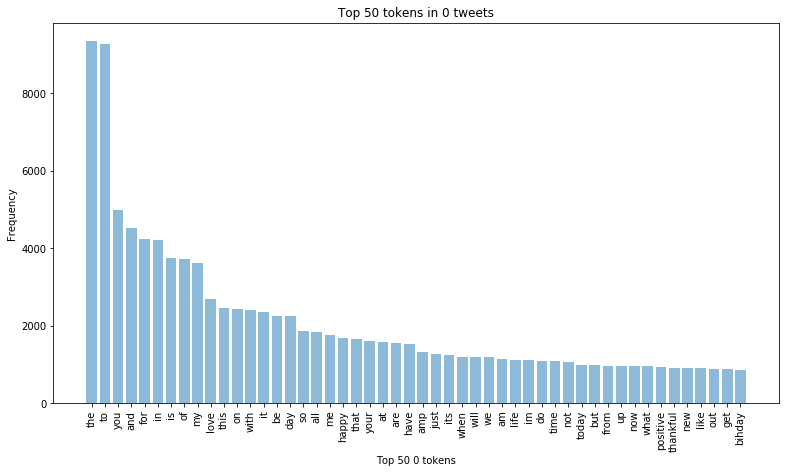

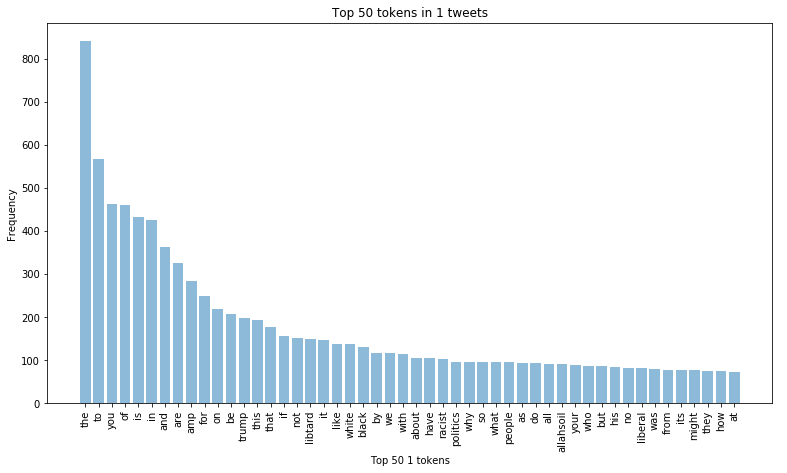

In [6]:
vab.tokens_and_more('label')

In [7]:
vab.normalizer('clean_tweet')
vab.auskunft()

{'Dataset_Length': 31962,
 'Columns': ['id',
  'label',
  'tweet',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': [0, 1],
 'Number_of_Classes': 2,
 'Transformed_Classes': [0, 1],
 'Vocabulary': 41308,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 24}

In [8]:
vab.data_here.head(3)

,id,label,tweet,target,clean_tweet,tokenized,tokenized_int
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run,"[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[169, 0, 3126, 0, 164, 0, 359]"
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthanked,"[thanks, lyft, credit, cant, use, cause, dont, offer, wheelchair, vans, pdx, disapointed, getthanked]","[96, 0, 2251, 18, 331, 520, 22, 1376, 0, 0, 0, 0, 0]"
2,3,0,bihday your majesty,0,bihday your majesty,"[bihday, majesty]","[16, 3127]"


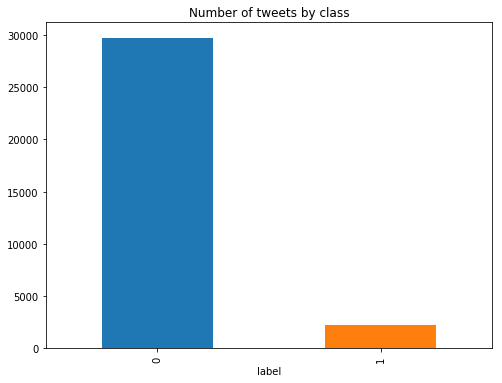

In [9]:
vab.prozent_wrt('label')

In [10]:
vab.auskunft()

{'Dataset_Length': 31962,
 'Columns': ['id',
  'label',
  'tweet',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': [0, 1],
 'Number_of_Classes': 2,
 'Transformed_Classes': [0, 1],
 'Vocabulary': 41308,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 24}

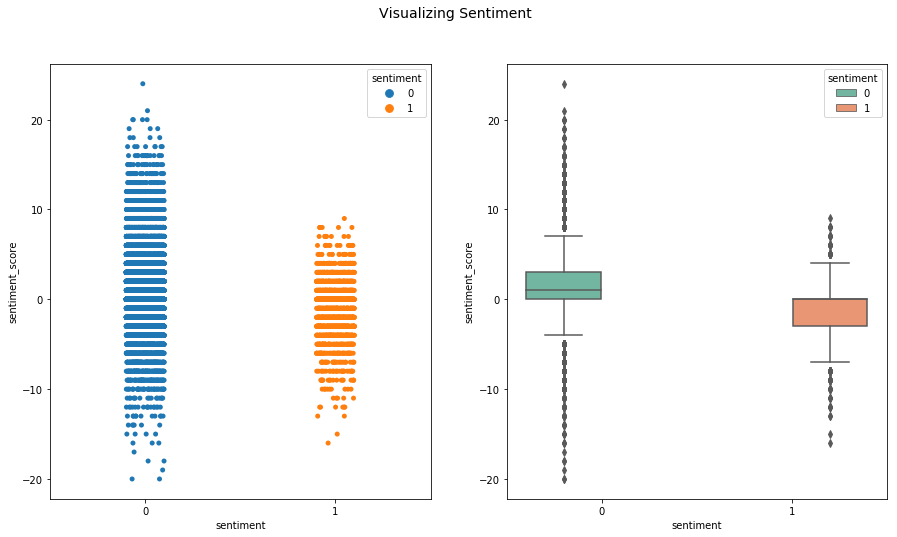

In [11]:
vab.afinn_stuff('label')

In [12]:
vab.auskunft()

{'Dataset_Length': 31962,
 'Columns': ['id',
  'label',
  'tweet',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': [0, 1],
 'Number_of_Classes': 2,
 'Transformed_Classes': [0, 1],
 'Vocabulary': 41308,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 24}

In [13]:
vab.patterns_of('label',0)

[('fathers day', 614),
 ('thankful positive', 404),
 ('positive affirmation', 352),
 ('love u', 345),
 ('cant wait', 332),
 ('u take', 326),
 ('take u', 326),
 ('model love', 325),
 ('u time', 325),
 ('time ur', 325),
 ('model love u', 325),
 ('love u take', 325),
 ('u take u', 325),
 ('take u time', 325),
 ('u time ur', 325),
 ('iam positive', 304),
 ('iam positive affirmation', 304),
 ('blog silver', 296),
 ('silver gold', 285),
 ('blog silver gold', 284)]

In [14]:
vab.patterns_of('label',1)

[('might libtard', 72),
 ('libtard libtard', 72),
 ('libtard sjw', 72),
 ('sjw liberal', 72),
 ('liberal politics', 72),
 ('might libtard libtard', 72),
 ('libtard libtard sjw', 72),
 ('libtard sjw liberal', 72),
 ('sjw liberal politics', 72),
 ('listen retweet', 51),
 ('feel like', 50),
 ('like stomping', 46),
 ('stomping listen', 43),
 ('stomping listen retweet', 43),
 ('feel like stomping', 42),
 ('like stomping listen', 41),
 ('black feel', 32),
 ('retweet tampa', 32),
 ('tampa miami', 32),
 ('black feel like', 32)]

In [15]:
vab.data_here.head(3)

,id,label,tweet,target,clean_tweet,tokenized,tokenized_int,grams
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run,"[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[169, 0, 3126, 0, 164, 0, 359]","[father dysfunctional, dysfunctional selfish, selfish drags, drags kids, kids dysfunction, dysfunction run, father dysfunctional selfish, dysfunctional selfish drags, selfish drags kids, drags kids dysfunction, kids dysfunction run]"
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthanked,"[thanks, lyft, credit, cant, use, cause, dont, offer, wheelchair, vans, pdx, disapointed, getthanked]","[96, 0, 2251, 18, 331, 520, 22, 1376, 0, 0, 0, 0, 0]","[thanks lyft, lyft credit, credit cant, cant use, use cause, cause dont, dont offer, offer wheelchair, wheelchair vans, vans pdx, pdx disapointed, disapointed getthanked, thanks lyft credit, lyft credit cant, credit cant use, cant use cause, use cause dont, cause dont offer, dont offer wheelchair, offer wheelchair vans, wheelchair vans pdx, vans pdx disapointed, pdx disapointed getthanked]"
2,3,0,bihday your majesty,0,bihday your majesty,"[bihday, majesty]","[16, 3127]",[bihday majesty]


In [16]:
vab.bert_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
5  experiments were run:  [0.9286757077986804, 0.9286608312047419, 0.9286608305084839, 0.9286608237697027, 0.9288545766479657]
Train on 23970 samples, validate on 7990 samples
Epoch 1/5
23970/23970 [==============================] - 1s 45us/step - loss: 0.2797 - acc: 0.9256 - val_loss: 0.2483 - val_acc: 0.9334

Epoch 00001: val_acc improved from -inf to 0.93342, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/bert_0.hdf5
Epoch 2/5
23970/23970 [==============================] - 1s 24us/step - loss: 0.2646 - acc: 0.9287 - val_loss: 0.2441 - val_acc: 0.9334

Epoch 00002: val_acc did not improve from 0.93342
Epoch 3/5
23970/23970 [==============================] - 1s 23us/step - loss: 0.2596 - acc: 0.9287 - val_loss: 0.2443 - val_acc: 0

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
vab.first_model()

5  experiments were run:  [0.9551616299885779, 0.9539007119800231, 0.960367133729797, 0.9574468109226744, 0.9574468114448678]
Train on 23971 samples, validate on 7991 samples
Epoch 1/5
23971/23971 [==============================] - 1s 47us/step - loss: 0.2393 - acc: 0.9290 - val_loss: 0.1486 - val_acc: 0.9451

Epoch 00001: val_acc improved from -inf to 0.94506, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/linear_0.hdf5
Epoch 2/5
23971/23971 [==============================] - 1s 26us/step - loss: 0.1099 - acc: 0.9579 - val_loss: 0.1216 - val_acc: 0.9581

Epoch 00002: val_acc improved from 0.94506 to 0.95808, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/linear_0.hdf5
Epoch 3/5
23971/23971 [==============================] - 1s 26us/step - loss: 0.0734 - acc: 0.9736 - val_loss: 0.1223 - val_acc: 0.9600

Epoch 00003: val_acc improved from 0.95808 to 0.95995, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/linear_0.hd

In [18]:
vab.data_here.head(5)

,id,label,tweet,target,clean_tweet,tokenized,tokenized_int,grams
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run,"[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[169, 0, 3126, 0, 164, 0, 359]","[father dysfunctional, dysfunctional selfish, selfish drags, drags kids, kids dysfunction, dysfunction run, father dysfunctional selfish, dysfunctional selfish drags, selfish drags kids, drags kids dysfunction, kids dysfunction run]"
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthanked,"[thanks, lyft, credit, cant, use, cause, dont, offer, wheelchair, vans, pdx, disapointed, getthanked]","[96, 0, 2251, 18, 331, 520, 22, 1376, 0, 0, 0, 0, 0]","[thanks lyft, lyft credit, credit cant, cant use, use cause, cause dont, dont offer, offer wheelchair, wheelchair vans, vans pdx, pdx disapointed, disapointed getthanked, thanks lyft credit, lyft credit cant, credit cant use, cant use cause, use cause dont, cause dont offer, dont offer wheelchair, offer wheelchair vans, wheelchair vans pdx, vans pdx disapointed, pdx disapointed getthanked]"
2,3,0,bihday your majesty,0,bihday your majesty,"[bihday, majesty]","[16, 3127]",[bihday majesty]
3,4,0,#model i love u take with u all the time in urã°âââ±!!! ã°âââã°âââã°âââã°âââ ã°âââ¦ã°âââ¦ã°âââ¦,0,model i love u take with u all the time in ur,"[model, love, u, take, u, time, ur]","[72, 1, 6, 27, 6, 8, 53]","[model love, love u, u take, take u, u time, time ur, model love u, love u take, u take u, take u time, u time ur]"
4,5,0,factsguide: society now #motivation,0,factsguide society now motivation,"[factsguide, society, motivation]","[2680, 1519, 198]","[factsguide society, society motivation, factsguide society motivation]"


In [19]:
vab.lstm_model()

5  experiments were run:  [0.9491136580612414, 0.9516061766723518, 0.9539007100404477, 0.9524405529014658, 0.9528577433161602]
Train on 23971 samples, validate on 7991 samples
Epoch 1/5
23971/23971 [==============================] - 7s 298us/step - loss: 0.2362 - acc: 0.9292 - val_loss: 0.1360 - val_acc: 0.9498

Epoch 00001: val_acc improved from -inf to 0.94982, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/lstm_0.hdf5
Epoch 2/5
23971/23971 [==============================] - 5s 228us/step - loss: 0.1007 - acc: 0.9635 - val_loss: 0.1266 - val_acc: 0.9576

Epoch 00002: val_acc improved from 0.94982 to 0.95758, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/lstm_0.hdf5
Epoch 3/5
23971/23971 [==============================] - 6s 244us/step - loss: 0.0740 - acc: 0.9741 - val_loss: 0.1324 - val_acc: 0.9542

Epoch 00003: val_acc did not improve from 0.95758
Epoch 4/5
23971/23971 [==============================] - 6s 250us/step - loss: 0.0591 -